MNIST handwritten Digit Classification

Importing the Dependencies

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # openCV library
# from google.colab.patches import cv2_imshow  # present in cv2 however google restrictions does not allow to use it directly (only for colab)
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from tensorflow.math import confusion_matrix
tf.random.set_seed(5)  # randomness restricted

2025-03-12 07:15:26.239251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading the MNIST data from keras.datasets

In [5]:
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data("mnist.npz") # preprocesing already done

In [6]:
type(x_train_org) # conversion to numpy also done

numpy.ndarray

In [7]:
x_train_org.shape, y_train_org.shape, x_test_org.shape, y_test_org.shape

# contains 60000 train images
# 10000 test images
# dimensions 28*28
# grey scale images asther is one channel and not 3 in case of RGB

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [8]:
print(x_train_org[20])
print(x_train_org[20].shape)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  38
  190  25   0   0   0   0   0   0   0   0]
 [  0   0   0  13  25  10   0   0   0   0   0   0   0   0   0   0   0 112
  252 125   4   0   0   0   0   0   0   0]
 [  0   0   0 132 252 113   0   0   0   0   0   0   0   0   0   0   0  61
  252 252  36   0   0   0   0   0   0   0]
 [  0   0   0 132 252 240  79   0   0   0   0   0   0   0   0   0   0  84
  252 252  36   0   0   0   0   0   0   0]
 [  0   0   0 132 252 252 238  52   0   0   0   0   0   0   0   

4


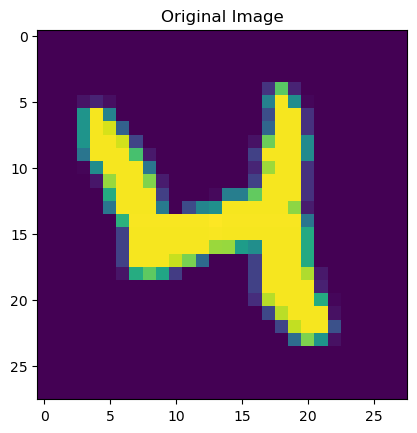

In [9]:
plt.imshow(x_train_org[20])
plt.title("Original Image")
plt.show

print(y_train_org[20])

Image Labels

In [11]:
print(y_train_org.shape, y_test_org.shape)

print(np.unique(y_train_org))
print(np.unique(y_test_org))

(60000,) (10000,)
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


Inverting the color and creating another dataset 

4


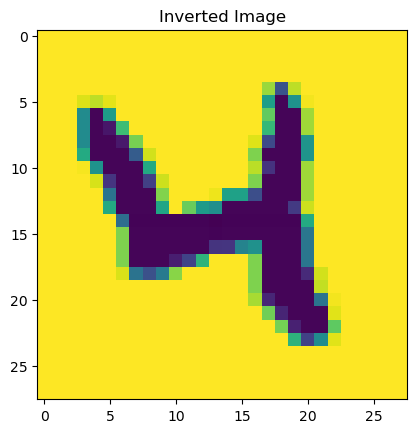

In [13]:
x_train_con = np.array(x_train_org)
x_test_con = np.array(x_test_org)

x_train_inv = (255 - x_train_con).astype(np.uint8)
x_test_inv = (255 - x_test_con).astype(np.uint8)
y_train_inv = y_train_org
y_test_inv = y_test_org

print(y_train_inv[20])
plt.imshow(x_train_inv[20])
plt.title("Inverted Image")
plt.show()

In [237]:
np.savez("mnist_inverted.npz",
         x_train=x_train_inv, y_train=y_train_inv,
         x_test=x_test_inv, y_test=y_test_inv)

x_train_inv.shape, y_train_inv.shape, x_test_inv.shape, y_test_inv.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Merging the dataets

In [235]:
x_train = np.concatenate((x_train_org, x_train_inv), axis=0)
y_train = np.concatenate((y_train_org, y_train_inv), axis=0)  

x_test = np.concatenate((x_test_org, x_test_inv), axis=0)
y_test = np.concatenate((y_test_org, y_test_inv), axis=0)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((120000, 28, 28), (120000,), (20000, 28, 28), (20000,))

normaliizing the scale

In [18]:
x_train = x_train/255
x_test = x_test/255

print(x_train[20])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

In [19]:
import tensorflow as tf

x_train = tf.image.per_image_standardization(x_train)
x_test = tf.image.per_image_standardization(x_test)

Model Training (Neural Network)

In [21]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),   # cannot input a 2-D array therefore it must be linearized into a line
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(56, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8515 - loss: 0.4707
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9462 - loss: 0.1755
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9576 - loss: 0.1390
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9654 - loss: 0.1125
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9695 - loss: 0.0983
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9725 - loss: 0.0884
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9756 - loss: 0.0788
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9769 - loss: 0.0749
Epoch 9/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9790 - loss: 0.0681
Epoch 10/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9799 - loss: 0.0649


Model Evaluation

In [24]:
loss, accuracy = model.evaluate(x_test, y_test)  # our model is not overfitting, as the accuracy on the test data is also high
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9692 - loss: 0.1148
Loss: 0.1138555034995079
Accuracy: 0.9710000157356262


taking one individual value

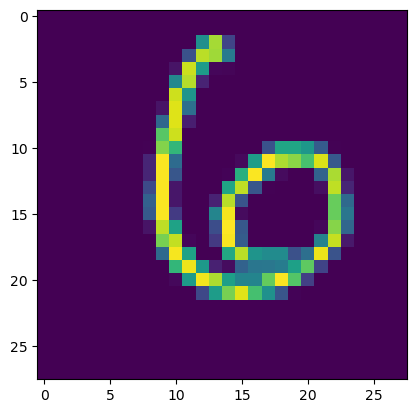

In [26]:
plt.imshow(x_test[100])
plt.show()

In [27]:
print(f"Actual Value: [{y_test[100]}]")

pred_100 = model.predict(x_test)[100]

print(f"Predicted Value: {pred_100}")
# output is probabilty of the 10 available classes ie 0-9
# position with the highest value indicates the prediction with highest probability
print(f"Predicted Answer: {np.argmax(pred_100)}")

Actual Value: [6]
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Predicted Value: [3.29784422e-09 1.85331825e-15 2.51338472e-16 2.54325428e-16
 4.56772620e-09 3.52061513e-09 1.00000000e+00 1.03363932e-13
 5.49829930e-12 1.30622814e-14]
Predicted Answer: 6


Confusion Matrix

In [29]:
y_prediction = model.predict(x_test)

#y_pred_ans = []
#for i in range (len(y_prediction)):
#  ans = np.argmax(y_prediction[i])
#  y_pred_ans.append(ans)

y_pred_ans = [np.argmax(i) for i in y_prediction]
conf_mat = confusion_matrix(y_test, y_pred_ans)

print(y_pred_ans)
print(conf_mat)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 4, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 5, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 2, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 0, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5

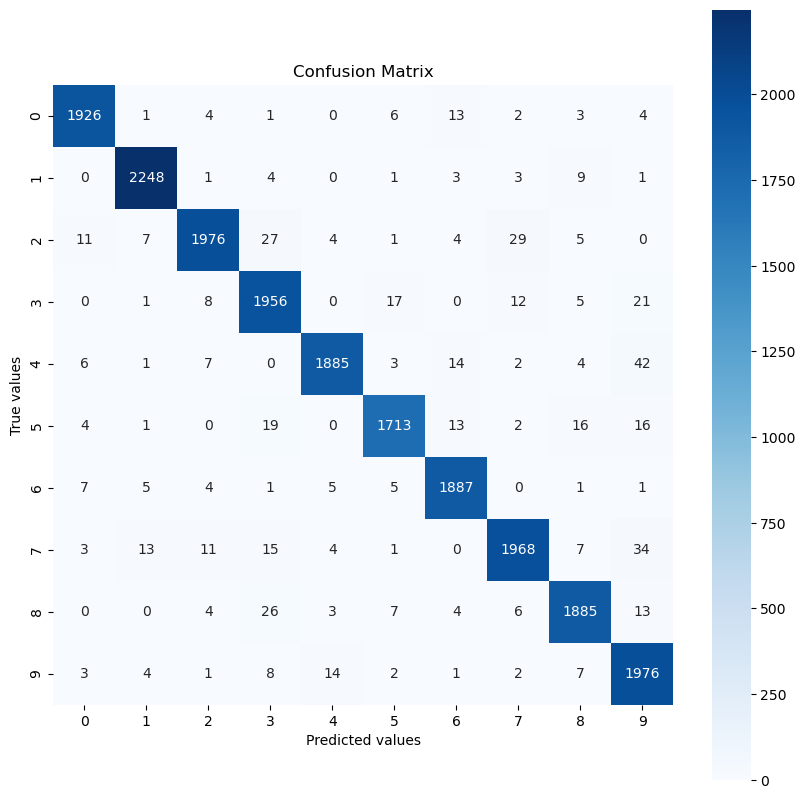

In [30]:
plt.figure(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', square=True)   # fmt='d' indicates that all values shouild be in integers
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion Matrix')
plt.show()

Building a predictive System

In [209]:
input1_img_path = 'Test_images/IMG_8.jpeg'

input1_img = cv2.imread(input1_img_path)

In [211]:
print(type(input1_img))
print(input1_img.shape) # read in as RGB image

<class 'numpy.ndarray'>
(263, 286, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

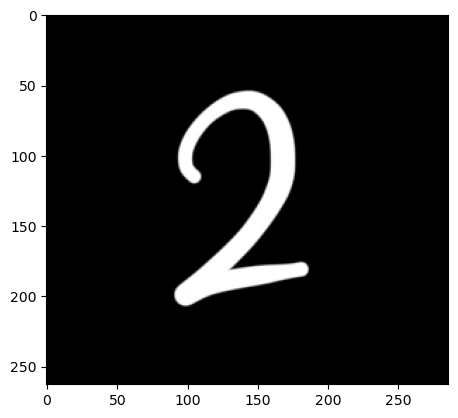

In [213]:
#cv2_imshow('Image', input1_img)  # for colab

#cv2.imshow('Image', input1_img) # for jupyter notebook using imshow
#cv2.waitKey(0)
#cv2.destroyAllWindows()

plt.imshow(input1_img)   # for jupyter notebook
plt.show

In [215]:
input1_greyscale_img = cv2.cvtColor(input1_img, cv2.COLOR_RGB2GRAY)   # converting RGB to greyscale
input1_greyscale_img.shape

(263, 286)

In [217]:
input1_img_resize = cv2.resize(input1_greyscale_img, (28,28))      # resizing the image as pre input of our NN
input1_img_resize.shape

(28, 28)

<function matplotlib.pyplot.show(close=None, block=None)>

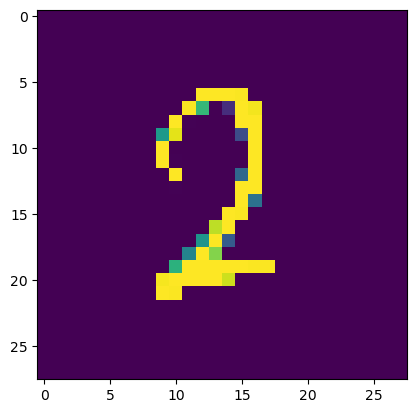

In [219]:
#cv2_imshow(input1_img_resize) # colab

plt.imshow(input1_img_resize)   # for jupyter notebook
plt.show

In [221]:
input1_image_resized = input1_img_resize/255   # normalization like before

In [223]:
image1_reshaped = np.reshape(input1_image_resized, [1,28,28])
# this indicates that we are only one image as input

In [225]:
input1_prediction = model.predict(image1_reshaped)
print(input1_prediction)
print(f"Predicted value: {np.argmax(input1_prediction)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
[[0.0173947  0.2460009  0.22376831 0.04191796 0.04520244 0.06021663
  0.04810567 0.13950746 0.12937015 0.0485158 ]]
Predicted value: 1


Creating a System

In [75]:
input_img_path = input("Enter path of the image: ")
input_img = cv2.imread(input_img_path)
grayscale_img = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
input_img_resize = cv2.resize(grayscale_img, (28,28))
input_img_resized = input_img_resize/255
image_reshaped = np.reshape(input_img_resized, [1,28,28])
input_prediction = model.predict(image_reshaped)
print(f"the handwritten image is: {np.argmax(input_prediction)}")


Enter path of the image:  Test_images/IMG_9_error.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
the handwritten image is: 8
